In [1]:
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

import networkx as nx
import networkx.algorithms.isomorphism as iso
import networkx.algorithms.similarity as sim
from IPython.display import clear_output

from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [3]:
csv_file = '../../datasets/fineExp_table2_on_file.csv'
txt_file = '../../datasets/subelements_fineExp.txt'

def divide_subgraph(csv_file, txt_file):
    """
    Reads files for extracting anomalous and correct subgraphs based on 
    IDs from a CSV file and a TXT file.
    
    Parameters:
    - csv_file: Path to the CSV file containing anomalous subgraph IDs.
    - txt_file: Path to the TXT file containing subgraphs.
    
    Returns:
    - '../../datasets/custom/anomalous_sub.txt' for anomalous subgraphs.
    - '../../datasets/custom/correct_sub.txt' for correct subgraphs.
    """
    print("Reading CSV file...")
    
    # Read the CSV file
    try:
        df = pd.read_csv(csv_file, sep=';', nrows=0)
    except FileNotFoundError:
        print(f"Error: The file '{csv_file}' was not found.")
        return
    
    # Extract anomalous subgraph IDs from the CSV header
    anomalous_ids = []
    
    for col in df.columns[1:]:
        # Extract the subject ID from the column name (e.g., 'Sub1' -> 1)
        sub_id = int(col.replace('Sub', ''))
        anomalous_ids.append(sub_id)
        
    print(f"Found {len(anomalous_ids)} anomalous subgraph in CSV file.")
    
    subgraphs = {}
    current_subgraph = None
    subgraph_counter = 0
    
    try:
        with open(txt_file, 'r') as f:
            for line in f:
                # Every time we encounter 'S', we start a new subgraph
                if line.strip() == 'S':
                    if current_subgraph:
                        subgraphs[subgraph_counter] = current_subgraph
                        
                    subgraph_counter += 1
                    current_subgraph = [line]
    
                else:
                    if current_subgraph is not None:
                        current_subgraph.append(line)
            
            # Save the last subgraph if it exists            
            if current_subgraph:
                subgraphs[subgraph_counter] = current_subgraph
    
    except FileNotFoundError:
        print(f"Error: The file '{txt_file}' was not found.")
        return
    
    print(f"Found {len(subgraphs)} subgraphs in TXT file.")
    
    with open('../../datasets/custom/anomalous_sub.txt', 'w') as f_anom, open('../../datasets/custom/correct_sub.txt', 'w') as f_corr:
        extracted_anom = 0
        extracted_corr = 0
        
        for sub_id, lines in subgraphs.items():
            if sub_id in anomalous_ids:
                f_anom.writelines(lines)
                f_anom.write('\n')
                extracted_anom += 1
            else:
                f_corr.writelines(lines)
                f_corr.write('\n')
                extracted_corr += 1
                
    print("\n--- Extraction Summary ---")
    print(f"Total anomalous subgraphs extracted: {extracted_anom}")
    print(f"Total correct subgraphs extracted: {extracted_corr}")
    
    # Check for any anomalous IDs that were requested but not found in the TXT file
    missing_ids = [sub_id for sub_id in anomalous_ids if sub_id not in subgraphs.keys()]
    print(f"Anomalous ID requested from CSV but not found in TXT: {missing_ids}")
    
divide_subgraph(csv_file, txt_file)

Reading CSV file...
Found 32 anomalous subgraph in CSV file.
Found 167 subgraphs in TXT file.

--- Extraction Summary ---
Total anomalous subgraphs extracted: 27
Total correct subgraphs extracted: 140
Anomalous ID requested from CSV but not found in TXT: [174, 176, 178, 179, 180]


In [4]:
def parse_subgraph(filepath):
    """
    Read subgraphs from a text file and return it as a list of direct graphs
    from NetworkX.
    
    Parameters:
    - filepath: Path to the text file containing subgraphs.
    
    Returns:
    A list of NetworkX directed graphs representing the subgraphs.
    """
    graphs = []
    G = None
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue # Skip empty lines
            
            if line == 'S':
                # Save the previous graph if it exists
                if G is not None and len(G.nodes) > 0:
                    graphs.append(G)
                
                 # Start a new graph
                G = nx.DiGraph()
            
            elif line.startswith('v '):
                # Extract node information
                # "v 1 CreateFine" -> ID: '1', Label: 'CreateFine'
                parts = line.split(maxsplit=2)
                if len(parts) >= 3:
                    node_id = parts[1]
                    label = parts[2]
                    G.add_node(node_id, label=label)
    
            elif line.startswith('d ') or line.startswith('e '):
                # Extract edge information
                # "d 1 2 next" -> Source: '1', Target: '2', Label: 'next'
                parts = line.split(maxsplit=3)
                if len(parts) >= 4:
                    source = parts[1]
                    target = parts[2]
                    edge_label = parts[3]
                    G.add_edge(source, target, label=edge_label)
    
    # Add the last graph if it exists
    if G is not None and len(G.nodes) > 0:
        graphs.append(G)
    
    return graphs

def print_graph_stats(name, graphs_list):
    "Print basic statistics about a list of graphs."
    
    num_nodes = [len(g.nodes) for g in graphs_list]
    num_edges = [len(g.edges) for g in graphs_list]
    
    print(f"\n--- {name} Graphs Statistics ---")
    print(f"Total graphs: {len(graphs_list)}")
    print(f"Average number of nodes (activity): {np.mean(num_nodes):.2f} (min: {np.min(num_nodes)}, max: {np.max(num_nodes)})")
    print(f"Average number of edges (transition): {np.mean(num_edges):.2f} (min: {np.min(num_edges)}, max: {np.max(num_edges)})\n")
    
# Parse the anomalous and correct subgraphs
anomalous_graphs = parse_subgraph('../../datasets/custom/anomalous_sub.txt')
correct_graphs = parse_subgraph('../../datasets/custom/correct_sub.txt')

# Print statistics
print_graph_stats("Anomalous", anomalous_graphs)
print_graph_stats("Correct", correct_graphs)


--- Anomalous Graphs Statistics ---
Total graphs: 27
Average number of nodes (activity): 5.89 (min: 2, max: 11)
Average number of edges (transition): 4.89 (min: 1, max: 10)


--- Correct Graphs Statistics ---
Total graphs: 140
Average number of nodes (activity): 7.11 (min: 2, max: 16)
Average number of edges (transition): 6.11 (min: 1, max: 15)



In [ ]:
node_match_kdmg = iso.categorical_node_match('label', None)
edge_match_kdmg = iso.categorical_edge_match('label', None)

def analyze_anomalous(anomalous_g, correct_graphs_list, timeout=2):
    """
    Analyze a single anomalous graph against a list of correct graphs to find
    the best match based on edit distance.
    
    Parameters:
    - anomalous_g: The anomalous graph to analyze.
    - correct_graphs_list: A list of correct graphs to compare against.
    - timeout: The maximum time to wait for a match (in seconds).
    Returns:
    - best_dist: The lowest edit distance found.
    - best_match_idx: The index of the best match in the correct_graphs_list.
    - best_edit_path: The edit path leading to the best match.
    """
    
    best_dist = float('inf')
    best_match_idx = -1
    best_edit_path = None
    
    for idx, correct_g in enumerate(correct_graphs_list):
        try:
            # Use the optimized edit path function to find
            # the best match and its distance
            paths = nx.optimize_edit_paths(
                anomalous_g, correct_g,
                node_match=node_match_kdmg,
                edge_match=edge_match_kdmg,
                timeout=timeout
            )
            
            node_edits, edge_edits, dist = next(paths)
            
            if dist < best_dist:
                best_dist = dist
                best_match_idx = idx
                best_edit_path = (node_edits, edge_edits)
                
                if dist == 0:
                    break  # Perfect match found, no need to continue
                
        except StopIteration:
            pass  # No path found, continue to the next graph
        
    return best_dist, best_match_idx, best_edit_path

results = []
tot_anomalous = len(anomalous_graphs)

print("\n--- Analysis Results ---")
for i, anom_g in enumerate(anomalous_graphs):
    dist, target_idx, path = analyze_anomalous(anom_g, correct_graphs)
    results.append({
        'id': i, 'target': target_idx, 'dist': dist, 'path': path
    })
    
clear_output(wait=True)
print("\n--- Analysis Results ---")
for res in results:
    if res['target'] == -1:
        print(f"Anomalous Graph ID {res['id']} has no match in correct graphs.")
        continue
    print(f"Anomalous Graph ID {res['id']} best matches Correct Graph ID {res['target']} with edit distance {res['dist']}.")
    
    anom_g = anomalous_graphs[res['id']]
    corr_g = correct_graphs[res['target']]
    node_edits, edge_edits = res['path']
    
    for n1, n2 in node_edits:
        if n1 is None:
            print(f"  - [INSERT] Missing '{corr_g.nodes[n2]['label']}'")
        elif n2 is None:
            print(f"  - [DELETE] Extra '{anom_g.nodes[n1]['label']}'")
        else:
            l1, l2 = anom_g.nodes[n1]['label'], corr_g.nodes[n2]['label']
            if l1 != l2:
                print(f"  - [REPLACE] '{l1}' -> '{l2}'")
    print("-" * 40)


--- Analysis Results ---
Anomalous Graph ID 0 best matches Correct Graph ID 54 with edit distance 2.0.
  - [INSERT] Missing 'Payment'
----------------------------------------
Anomalous Graph ID 1 best matches Correct Graph ID 22 with edit distance 2.0.
  - [INSERT] Missing 'Payment'
----------------------------------------
Anomalous Graph ID 2 best matches Correct Graph ID 24 with edit distance 2.0.
  - [INSERT] Missing 'AddPenalty'
----------------------------------------
Anomalous Graph ID 3 best matches Correct Graph ID 0 with edit distance 2.0.
  - [INSERT] Missing 'SendAppeal'
----------------------------------------
Anomalous Graph ID 4 best matches Correct Graph ID 10 with edit distance 4.0.
  - [DELETE] Extra 'SendForCreditCollection'
  - [DELETE] Extra 'SendAppeal'
----------------------------------------
Anomalous Graph ID 5 best matches Correct Graph ID 48 with edit distance 2.0.
  - [INSERT] Missing 'Payment'
----------------------------------------
Anomalous Graph ID 6 be

### **Hierarchical Agglomerative Clustering (Clustering Gerarchico)**

Si utilizza la **matrice delle distanze** precedentemente calcolata (basata su Graph Edit Distance) per eseguire un clustering di tipo gerarchico agglomerativo. Questa scelta è indicata per l'analisi topologica per avere:

- **Approccio Data-Driven (Bottom-up)**: a differenza di algoritmi classici, non richiede di definire a priori il numero di cluster (k). L'algoritmo lascia che siano le reali distanze topologiche a guidare la frammentazione del dataset.

- **Gestione di spazi Non-Euclidei**: per dei sottografi orientati, non si dispone di coordinate geometriche per calcolare centroidi tradizionali. L'algoritmo consuma solamente le distanze relazionali fornite dalla matrice.

- **Esplorabilità Visiva**: la costruzione di un Dendrogramma offre una mappa visiva della "deriva procedurale" (Procedural Drift), permettendo di individuare la soglia di taglio ideale per separare le micro-deviazioni locali da problemi strutturali più gravi.

Distance matrix calculation completed.


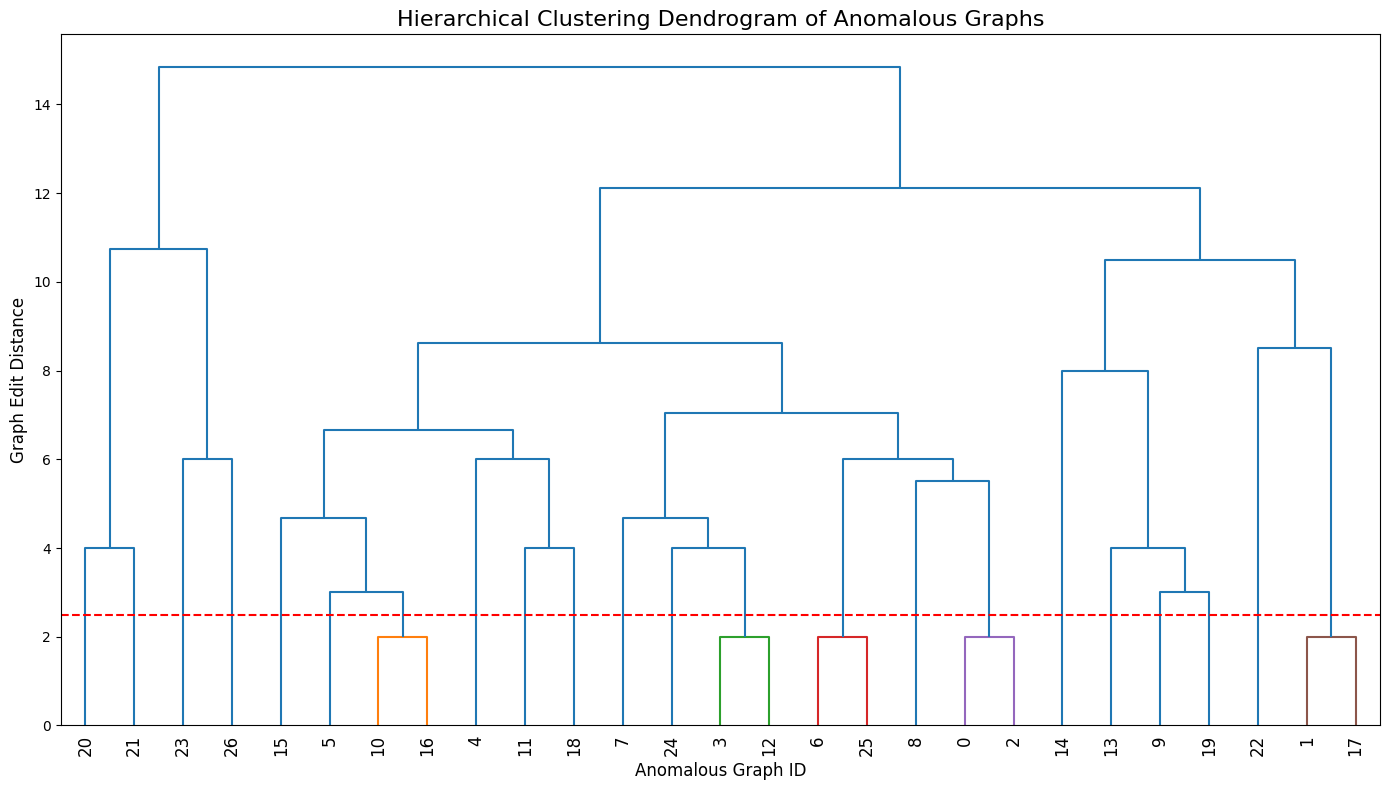

In [ ]:
n_anomalies = len(anomalous_graphs)

# Initialize distance matrix
distance_matrix = np.zeros((n_anomalies, n_anomalies))

print(f"Calculating distance matrix for {n_anomalies} anomalous graphs...")
print(f"Total comparisons: {n_anomalies * (n_anomalies - 1) // 2}")

comparisons_done = 0
for i in range(n_anomalies):
    for j in range(i + 1, n_anomalies):
        
        # Compute the edit distance between anomalous_graphs[i]
        # and anomalous_graphs[j]
        try:
            paths = nx.optimize_edit_paths(
                anomalous_graphs[i], anomalous_graphs[j],
                node_match=node_match_kdmg,
                edge_match=edge_match_kdmg,
                timeout=1.5
            )
            
            # Get the edit distance
            _, _, dist = next(paths)
        
        # If no path is found, set the distance to 10    
        except StopIteration:
            dist = 10.0
            
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist
        
        comparisons_done += 1
        if comparisons_done % 50 == 0:
            print(f" - Completed {comparisons_done}/{n_anomalies * (n_anomalies - 1) // 2} comparisons...")
            
clear_output(wait=True)

# Perform hierarchical clustering
condensed_dist_matrix = squareform(distance_matrix)

# Use average linkage for clustering
# other methods: 'single', 'complete', 'ward'
Z = linkage(condensed_dist_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(14, 8))
plt.title("Hierarchical Clustering Dendrogram of Anomalous Graphs", fontsize=16)
plt.xlabel("Anomalous Graph ID", fontsize=12)
plt.ylabel("Graph Edit Distance", fontsize=12)

# Construct the dendrogram
# Threshold=2.5 for isolating clusters of minimal structural variations
dendro = dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold=2.5
)

plt.axhline(y=2.5, color='r', linestyle='--', label='Distance Threshold')
plt.tight_layout()
plt.show()

#### **Analisi del Dendrogramma**

Si può subito osservare che, le uniche fusioni sotto la soglia scelta (*Y=2.5*), avvengono tutte a quota *Y=2.0*:
- [10,16] (Arancione)
- [3,12] (Verde)
- [6,25] (Rossa)
- [0,2] (Viola)
- [1,17] (Marrone)

Queste coppie rappresentano i grafi più simili in assoluto tra loro in tutta la rete (distano solo 2 operazioni strutturali l'uno dall'altro).

Tutti gli altri grafi, si uniscono a distanze più alte quasi sempre a Cluster già esistenti, tranne per le coppie [20,21] (*Y=4*), [23,26] (*Y=6*), [11,18] (*Y=4*) e [9,19] (*Y=3*).

Il dendrogramma, quindi, dimostra visivamente che **c'è un'altissima variabilità topologica**: uno stesso errore può avvenire all'interno di sottografi molto diversi tra loro.

### **K-Medoids (PAM - Partition Around Medoids)**

L'algoritmo K-Medoids permette di estrarre un elemento reale del dataset (il **Medoide**) come centro del cluster, permettendo di isolare il grafo anomalo tipico per ogni violazione, lavorando sempre con la matrice GED calcolata.

- **Fase 1: Ricerca del *K* ottimale**: iterando su un range di *k*, il codice calcola il **Silhouette Score** e traccia l'**Elbow Method** per trovare matematicamente la suddivisione più pulita.

- **Fase 2: Estrazione e coesione**: individuato il *k* migliore, il modello viene addestrato per estrarre gli ID dei Medoidi.

Best K based on silhouette score: 10 (Score: 0.3899)


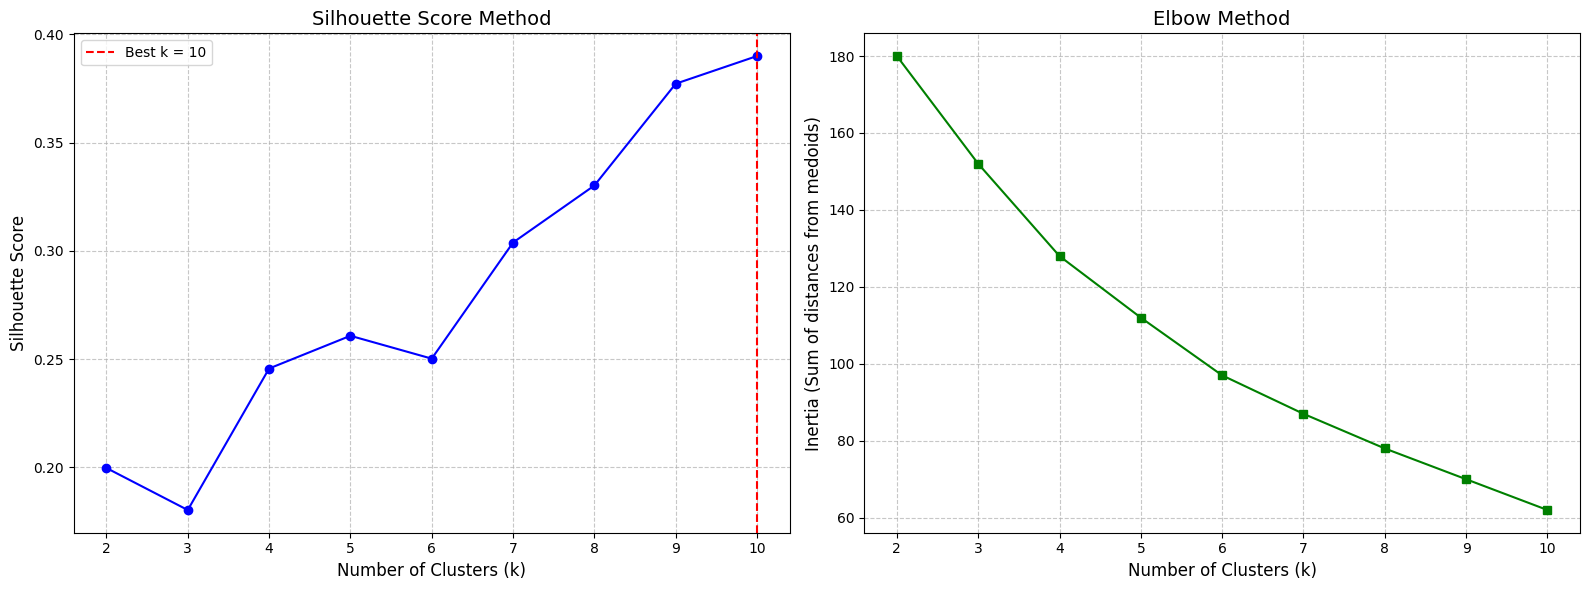

In [7]:
K_MIN = 2
K_MAX = 10
range_k = range(K_MIN, K_MAX + 1)

silhouette_scores = []
inertias = [] # Sum of distances from Medoids

for k in range_k:
    # Initialize and fitting K-Medoids
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42, method='pam', init='heuristic')
    labels = kmedoids.fit_predict(distance_matrix)
    
    # Calculate silhouette score
    score = silhouette_score(distance_matrix, labels, metric='precomputed')
    silhouette_scores.append(score)
    
    # Calculate inertia
    inertias.append(kmedoids.inertia_)
    
# Find best K based on silhouette score
best_k = range_k[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"Best K based on silhouette score: {best_k} (Score: {best_score:.4f})")

# Plot Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Silhouette Scores
ax1.plot(range_k, silhouette_scores, marker='o', linestyle='-', color='blue')
ax1.set_title('Silhouette Score Method', fontsize=14)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# 2. Elbow Method
ax2.plot(range_k, inertias, marker='s', linestyle='-', color='green')
ax2.set_title('Elbow Method', fontsize=14)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Inertia (Sum of distances from medoids)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [8]:
best_k = 10

# Initialize and fitting K-Medoids
kmedoids = KMedoids(n_clusters=best_k, metric='precomputed', random_state=42, method='pam', init='heuristic')

# Fit the model and get cluster labels
cluster_labels = kmedoids.fit_predict(distance_matrix)

# Get medoid indices
medoid_indices = kmedoids.medoid_indices_

for cluster_id in range(best_k):
    # Find all IDs of graphs in the current cluster
    members = np.where(cluster_labels == cluster_id)[0]
    medoid = medoid_indices[cluster_id]
    
    print(f"\n--- Cluster {cluster_id} (Dimensions: {len(members)}) graphs) ---")
    print(f"Medoid Graph ID: {medoid}")
    print(f"Members: {members.tolist()}")
    
    # Calculate average distance to medoid
    if len(members) > 1:
        avg_dist = np.mean(distance_matrix[medoid, members])
        print(f"    -> Average distance to medoid: {avg_dist:.2f}")
    else:
        print("    -> Only one member in this cluster.")


--- Cluster 0 (Dimensions: 2) graphs) ---
Medoid Graph ID: 20
Members: [20, 21]
    -> Average distance to medoid: 2.00

--- Cluster 1 (Dimensions: 4) graphs) ---
Medoid Graph ID: 16
Members: [5, 10, 15, 16]
    -> Average distance to medoid: 2.25

--- Cluster 2 (Dimensions: 4) graphs) ---
Medoid Graph ID: 12
Members: [3, 7, 12, 24]
    -> Average distance to medoid: 2.50

--- Cluster 3 (Dimensions: 2) graphs) ---
Medoid Graph ID: 17
Members: [1, 17]
    -> Average distance to medoid: 1.00

--- Cluster 4 (Dimensions: 1) graphs) ---
Medoid Graph ID: 22
Members: [22]
    -> Only one member in this cluster.

--- Cluster 5 (Dimensions: 3) graphs) ---
Medoid Graph ID: 0
Members: [0, 2, 8]
    -> Average distance to medoid: 2.00

--- Cluster 6 (Dimensions: 2) graphs) ---
Medoid Graph ID: 23
Members: [23, 26]
    -> Average distance to medoid: 3.00

--- Cluster 7 (Dimensions: 2) graphs) ---
Medoid Graph ID: 25
Members: [6, 25]
    -> Average distance to medoid: 1.00

--- Cluster 8 (Dimension

#### **Cluster compatti (Distanza <= 2.0)**

I cluster **0, 3, 5 e 7** sono estremamente coesi (distanza media tra 1.0 e 2.0). Questo significa che i grafi al loro interno sono tutti molto simili.

*Esempio: il Cluster 0 raggruppa gli ID 20 e 21. Le anomalie riferiti a questi ID erano rispettivamente `[DELETE] Extra 'Payment'` (ripetuto due volte) e `[DELETE] Extra 'Payment'`. L'algoritmo ha capito che si tratta della stessa tipologia di errore strutturale, mettendoli insieme.*

#### **Cluster più variegati (Distanza >= 3.0)**

I cluster **6, 8 e 9** hanno una distanza media superiore (tra 3.0 e 3.5). Le anomalie, in questo caso, pur avendo etichette di errore leggermente diverse, condividono una struttura di base molto simile.

*Esempio: derivano tutti da tracce in cui il processo è arrivato fino ad uno stadio avanzato come il `SendForCreditCollection` o i vari `Appeal`.*

#### **Cluster solitario (Cluster 4)**

Il grafo ID 22 forma un cluster a sé stante. Anche se l'errore era un `[INSERT] Missing 'Payment'`, la struttura globale del grafo attorno a questo errore è così peculiare da non poter essere assimilata a nessun'altra anomalia nel dataset. Quindi, è stato classificato come un *outlier*.

### **Semantic / Edit-Path Clustering**

Mentre i precedenti algoritmi raggruppano i grafi in ase a distanze numeriche astratte, l'approccio **semantic / edit-path** effettua un raggruppamento **semantico e perfettamente interpretabile**, basato sulla natura dell'errore commesso:

- **1. Estrazione delle Modifiche Topologiche**: per ogni grafo anomalo, si legge il percorso ottimale di *Graph Edit Distance* e traduce le singole operazioni matematiche in regole umane leggibili:
    - **INSERT**: inserimento di un nuovo nodo;
    - **DELETE**: eliminazione di un nodo;
    - **REPLACE**: sostituzione di un nodo con un altro.

- **2. Creazione della Firma Semantica (Signature)**: le descrizioni estratte vengono unificate in un'unica stringa.

- **3. Raggruppamento Semantico**: le descrizioni semantiche vengono raggruppate in base alla loro similitudine.

Il risultato è una mappatura delle deviazioni di processo (ordinata per frequenza), che permette di identificare quali specifiche attività (nodi) sono le **cause radice** più frequenti delle anomalie. Quindi, evidenziando la concentrazione degli errori su specifiche attività, questa tecnica permette di identificare empiricamente quali nodi rappresentano i **colli di bottiglia** o i punti critici di maggiore vulnerabilità dell'intero processo.

In [9]:
# Create semantic clusters based on edit signatures
semantic_clusters = defaultdict(list)

for res in results:
    anom_id = res['id']
    target_idx = res['target']
    
    if target_idx == -1:
        semantic_clusters['[NO MATCH] No correct graph found'].append(anom_id)
        continue
    
    anom_g = anomalous_graphs[anom_id]
    corr_g = correct_graphs[target_idx]
    node_edits, edge_edits = res['path']
    
    # Create a description of the edits
    edit_descriptions = []
    
    for n1, n2 in node_edits:
        if n1 is None:
            label = corr_g.nodes[n2]['label']
            edit_descriptions.append(f"[INSERT] Missing '{label}'")
        elif n2 is None:
            label = anom_g.nodes[n1]['label']
            edit_descriptions.append(f"[DELETE] Extra '{label}'")
        else:
            l1, l2 = anom_g.nodes[n1]['label'], corr_g.nodes[n2]['label']
            if l1 != l2:
                edit_descriptions.append(f"[REPLACE] '{l1}' -> '{l2}'")
                
    if not edit_descriptions:
        edit_descriptions.append("[STRUCTURAL] Edits only on edges/transitions")
    
    # Sort the edit descriptions to ensure consistent signatures
    edit_descriptions.sort()
    
    # Unify the edit descriptions into a single signature string
    signature = " AND ".join(edit_descriptions)
    
    # Group anomalous graph IDs by their edit signatures
    semantic_clusters[signature].append(anom_id)
    
# Sort clusters by size
sorted_clusters = sorted(semantic_clusters.items(), key=lambda x: len(x[1]), reverse=True)
    
# Print the semantic clusters and their members
for i, (signature, members) in enumerate(sorted_clusters):
    print(f"\n--- Semantic Cluster {i} (Size: {len(members)} graphs) ---")
    print(f"Edit Signature: {signature}")
    print(f"Members: {members}")


--- Semantic Cluster 0 (Size: 7 graphs) ---
Edit Signature: [INSERT] Missing 'Payment'
Members: [0, 1, 5, 6, 13, 15, 22]

--- Semantic Cluster 1 (Size: 1 graphs) ---
Edit Signature: [INSERT] Missing 'AddPenalty'
Members: [2]

--- Semantic Cluster 2 (Size: 1 graphs) ---
Edit Signature: [INSERT] Missing 'SendAppeal'
Members: [3]

--- Semantic Cluster 3 (Size: 1 graphs) ---
Edit Signature: [DELETE] Extra 'SendAppeal' AND [DELETE] Extra 'SendForCreditCollection'
Members: [4]

--- Semantic Cluster 4 (Size: 1 graphs) ---
Edit Signature: [REPLACE] 'Payment' -> 'SendAppeal'
Members: [7]

--- Semantic Cluster 5 (Size: 1 graphs) ---
Edit Signature: [REPLACE] 'AppealToJudge' -> 'Notification'
Members: [8]

--- Semantic Cluster 6 (Size: 1 graphs) ---
Edit Signature: [REPLACE] 'Payment' -> 'AppealToJudge'
Members: [9]

--- Semantic Cluster 7 (Size: 1 graphs) ---
Edit Signature: [REPLACE] 'Payment' -> 'NotifyOffenders'
Members: [10]

--- Semantic Cluster 8 (Size: 1 graphs) ---
Edit Signature: [DELE

#### **Cluster 0 (Missing Payment)**

Questo Cluster raggruppa 7 grafi (più del 25% delle anomalie): ciò significa che nel processo c'è un pattern ricorrente e preciso per cui l'attività di `Payment` viene saltata in blocco.

#### **Colli di bottiglia**

Più del 50% delle anomalie riguardano un solo nodo. Infatti, rilassando la regola (senza osservare Insert/Delete/Replace) si osserva che:
- **Cluster 0**: manca 'Payment' (7 grafi);
- **Cluster 4, 6, 7**: sostituiscono 'Payment' con altro (3 grafi);
- **Cluster 12, 19**: sostituiscono altro con 'Payment' (2 grafi);
- **Cluster 15, 16**: hanno 'Payment' in eccesso/duplicati (2 grafi);
- **Cluster 17**: misto duplicato/sostituito su 'Payment' (1 grafo).

Quindi, 15 grafi su 27 hanno un'anomalia legata al nodo `Payment`, che può essere quindi inteso come un nodo **collo di bottiglia** o punto critico del modello di processo.

Può essere applicato lo stesso ragionamento agli altri Cluster, osservando una seconda macro-cagegoria:
- **Cluster 2, 3, 10**: riguardano `SendAppeal`;
- **Cluster 5, 9, 11, 14**: riguardano `AppealToJudge`;
- **Cluster 13, 18**: riguardano `AppealToPrefecture`.

Quindi, le attività di ricorso sono la seconda causa di deviazione del processo, che vengono spesso inserite in eccesso, saltate o scambiate tra loro.

### **Classificazione per Natura Topologica e Severità**

Per elevare l'analisi oltre lo specifico dominio applicativo, si introduce una classificazione basata esclusivamente sulla forma e sul peso strutturale dell'errore.

Analizzando il percorso di *Graph Edit Distance*, si estraggono due dimensioni per ogni anomalia:

- **Natura topologica dell'anomalia**: Le operazioni matematiche vengono mappate in categorie standard del *Process Mining*:
    - **Omissioni Pure (Missing Nodes)**: solo operazioni di `[INSERT]`;
    - **Commissioni Pure (Extra Nodes)**: solo operazioni di `[DELETE]`;
    - **Sostituzioni Pure (Wrong Nodes)**: solo operazioni di `[REPLACE]`;
    - **Anomalie Miste**: una combinazione delle precedenti, utile per identificare eventuali effetti a cascata.

- **Severità della Deviazione**: il costo totale della GED viene utilizzato per classificare la profondità della deriva procedurale:
    - **Lieve (GED<=2)**: micro-deviazioni, dove il processo si distacca minimamente prima di rientrare nel modello normativo;
    - **Moderata (GED 3-4)**: deviazioni strutturali intermedie;
    - **Grave (GED>=5)**: discostamenti radicali dal comportamento atteso.

Questo permette di valutare statisticamente se il sistema sia più incline a errori di dimenticanza, esecuzioni non richieste o deviazioni a catena complesse, a prescindere dal contesto.

In [10]:
clusters_dict = defaultdict(list)

for res in results:
    anom_id = res['id']
    dist = res['dist']
    
    if res['target'] == -1:
        clusters_dict['[NO MATCH] No correct graph found'].append(anom_id)
        continue
    
    node_edits, edge_edits = res['path']
    
    # Counters for different types of operations
    inserts = 0
    deletes = 0
    replaces = 0
    
    for n1, n2 in node_edits:
        if n1 is None:
            inserts += 1
        elif n2 is None:
            deletes += 1
        else:
            # Check if the labels are different for a replace operation
            anom_g = anomalous_graphs[anom_id]
            corr_g = correct_graphs[res['target']]
            if anom_g.nodes[n1]['label'] != corr_g.nodes[n2]['label']:
                replaces += 1
                
    # 1. Determine Structural Nature of anomaly
    if inserts > 0 and deletes == 0 and replaces == 0:
        nature = "Pure Omission (Missing Nodes)"
    elif deletes > 0 and inserts == 0 and replaces == 0:
        nature = "Pure Commission (Extra Nodes)"
    elif replaces > 0 and inserts == 0 and deletes == 0:
        nature = "Pure Replacement (Wrong Nodes)"
    elif inserts == 0 and deletes == 0 and replaces == 0:
        nature = "Routing Anomaly (Only Edge Changes)"
    else:
        nature = "Mixed Anomaly (Combination of Edits)"
        
    # 2. Determine Severity based on Graph Edit Distance
    if dist <= 2.0:
        severity = "Low Severity (GED <= 2)"
    elif dist <= 4.0:
        severity = "Moderate Severity (GED 3-4)"
    else:
        severity = "High Severity (GED >= 5)"
        
    # Create signature combining nature and severity
    signature = f"Nature: {nature} | Severity: {severity}"
    clusters_dict[signature].append(anom_id)
    
# Sort clusters by size
sorted_clusters = sorted(clusters_dict.items(), key=lambda x: len(x[1]), reverse=True)

for i, (signature, members) in enumerate(sorted_clusters):
    percentage = (len(members) / len(anomalous_graphs)) * 100
    print(f"\n Pattern {i} | Frequency: {len(members)} graphs ({percentage:.2f}%)")
    print(f"     Signature: {signature}")
    print(f"     Members: {members}")


 Pattern 0 | Frequency: 9 graphs (33.33%)
     Signature: Nature: Pure Omission (Missing Nodes) | Severity: Low Severity (GED <= 2)
     Members: [0, 1, 2, 3, 5, 6, 13, 15, 22]

 Pattern 1 | Frequency: 5 graphs (18.52%)
     Signature: Nature: Pure Replacement (Wrong Nodes) | Severity: Moderate Severity (GED 3-4)
     Members: [7, 8, 9, 17, 19]

 Pattern 2 | Frequency: 4 graphs (14.81%)
     Signature: Nature: Pure Commission (Extra Nodes) | Severity: Moderate Severity (GED 3-4)
     Members: [4, 14, 18, 20]

 Pattern 3 | Frequency: 4 graphs (14.81%)
     Signature: Nature: Pure Replacement (Wrong Nodes) | Severity: Low Severity (GED <= 2)
     Members: [10, 16, 24, 25]

 Pattern 4 | Frequency: 4 graphs (14.81%)
     Signature: Nature: Pure Commission (Extra Nodes) | Severity: Low Severity (GED <= 2)
     Members: [11, 12, 21, 26]

 Pattern 5 | Frequency: 1 graphs (3.70%)
     Signature: Nature: Mixed Anomaly (Combination of Edits) | Severity: Moderate Severity (GED 3-4)
     Members:

#### **Profilo di severità**

Analizzando le percentuali dei grafi riguardo la severità, si possono trarre delle conclusioni riguardo la stabilità del processo:
- **Bassa Severità (GED <=2)**: 63% dei grafi (Pattern 0,3,4);
- **Severità Moderata (GED 3-4)**: 37% dei grafi (Pattern 1,2,5);
- **Severità Alta (GED >=5)**: 0%.

Il sistema non subisce mai collassi strutturali gravi (nessun grafo ha GED>=5). Le anomalie sono localizzate: il flusso si distacca dal modello normativo per un massimo di 2-4 operazioni strutturali (nodi saltati o aggiunti).

#### **Tipologia degli errori**

Indipendentemente dalla severità, guardando alla natura degli errori, il dataset si divide quasi in tre terzi perfetti:

- **Omissioni (Missing Nodes)**: 33.3% (Pattern 0);
- **Sostituzioni (Wrong Nodes)**: 33.3% (Pattern 1 + 3);
- **Commissioni (Extra Nodes)**: 29.6% (Pattern 2 + 4).

Il processo è equamente vulnerabile a tutte e tre le macro-categorie di errore topologico. Gli utenti (o il sistema) hanno la stessa probabilità di dimenticare uno step obbligatorio, di eseguirne uno non richiesto, o di eseguire l'azione sbagliata al momento giusto.

#### **Purezza delle anomalie**

Il pattern 5 (Anomalia Mista) rappresenta solo il 3.70%  del totale (1 solo grafo). Le deviazioni del processo sono "pure": quando si verifica un'anomalia, questa tende ad appartenere a una singola classe topologica (solo omissioni, commissioni o sostituzioni). Si può notare che non si osserva un **effetto valanga**, in cui un errore di omissione innesca successivamente la necessità di commissioni compensative.

*Si ipotizza che l'assenza di questo effetto sia una caratteristica intrinseca dell'algoritmo di generazione delle anomalie (BIG) utilizzato.
Gli algoritmi di iniziezione tendono ad applicare perturbazioni atomiche per preservare la tracciabilità del Ground Truth, differendo però dalle anomalie organiche del mondo reale, dove una singola deviazione procedurale innesca spesso loop compensativi o errori a cascata.*

Prossimi step -> Global Topological Profiling/Joint Clustering Analysis.
Mescolare grafi corretti e anomali ed effettuare dei clustering per:
- capire se le anomalie formano cluster separati o si mimetizzano dentro i cluster dei grafi corretti;
- scoprire se una specifica anomalia deriva sempre e solo da una variante A del processo, o se colpisce tutte le varianti indistintamente;

Metodi:
- Joint Clustering con i grafi corretti, calcolando GED su tutti (dispendioso);
- Clustering delle "Normalità" + Proiezione anomalie: si calcola la GED solo tra i grafi corretti, si clusterizzano con K-Medoids e poi, per ogni anomalia, si osserva a quale Medoide corretto è più vicino;
- Vectorizzazione e Proiezione Spaziale 2D (PCA/t-SNE): si trasforma ogni grafo in un vettore di features e poi si plotta su un grafico.
